# Diabetic Retinopathy Classification

In this notebook I trained Inception v3 model using dataset that rescaled only, without any image processing.

In [1]:
!nvidia-smi

Sun Jan 17 10:58:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 456.71       Driver Version: 456.71       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1070   WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   59C    P8    15W / 151W |   1111MiB /  8192MiB |     11%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [2]:
!dir "D:/Datasets/thesis_dr/aptos2019/"

 Volume in drive D is Storage space
 Volume Serial Number is 3C35-EA61

 Directory of D:\Datasets\thesis_dr\aptos2019

01/07/2021  06:43 AM    <DIR>          .
01/07/2021  06:43 AM    <DIR>          ..
12/18/2019  03:27 AM            54,948 aptos_train.csv
03/20/2020  10:02 AM               124 desktop.ini
12/06/2020  07:57 AM         1,235,300 df_train_dhash - Copy.csv
12/26/2020  12:59 PM           702,068 df_train_dhash - Copy.xlsx
12/06/2020  07:57 AM         1,235,300 df_train_dhash.csv
01/15/2021  10:30 PM    <DIR>          models
01/04/2021  07:50 PM    <DIR>          models - Copy
12/21/2020  07:33 AM    30,245,087,887 models.7z
01/07/2021  12:14 PM    <DIR>          models_alpha
01/06/2021  10:12 AM    <DIR>          models_without_l2
12/18/2019  03:23 AM            28,938 sample_submission.csv
12/17/2020  02:28 PM            25,072 test.csv
10/10/2020  08:35 AM    <DIR>          test_images
12/17/2020  02:28 PM            54,948 train.csv
01/06/2021  11:23 PM    <DIR>        

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
# import library
import os
import datetime
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, metrics, losses, optimizers, models, callbacks, utils, initializers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

from matplotlib import pyplot as plt
# plt.style.use('dark_background')

In [5]:
# define our working directory
dir_base = 'D:/Datasets/thesis_dr/aptos2019/'
dir_img = os.path.join(dir_base,
                       'train_images_300/train_images_rescaled_300_jpeg/')

In [6]:
image_shape = (299, 299, 3)
batch_size = 32

# Prepare dataframe

- Split train & test
- Compute weight for each class

In [7]:
# load csv file that contains our image file name & its label
df = pd.read_csv(os.path.join(dir_base, 'df_train_dhash.csv'))
df

id_code  diagnosis  is_exist  \
0     000c1434d8d7.png          2      True   
1     001639a390f0.png          4      True   
2     0024cdab0c1e.png          1      True   
3     002c21358ce6.png          0      True   
4     005b95c28852.png          0      True   
...                ...        ...       ...   
3657  ffa47f6a7bf4.png          2      True   
3658  ffc04fed30e6.png          0      True   
3659  ffcf7b45f213.png          2      True   
3660  ffd97f8cd5aa.png          0      True   
3661  ffec9a18a3ce.png          2      True   

                                                  dhash  freq keep  
0     4505549846649357848361897357201341356077337430...     1  yes  
1     2329637184878609198035515006640525134579216941...     1  yes  
2     2423240825355712633243422248054645083667877231...     1  yes  
3     6900833685078708622050523299339707984650415156...     1  yes  
4     1596672251484725956711788094558338750112176232...     1  yes  
...                                                 ...   ...  ...  
3657  1714415029888012417314661111083115996014360412...     1  yes  
3658  1596672252599988637907833311359172559898032526...     1  yes  
3659  2371174750225767638951270617106319090295289270...     1  yes  
3660  4495615386714830418073151623371454397778002504...     1  yes  
3661  8797082316593930222949141631319107819201625754...     1  yes  

[3662 rows x 6 columns]

In [8]:
df.groupby('diagnosis')[['id_code']].count()

id_code
diagnosis         
0             1805
1              370
2              999
3              193
4              295

In [9]:
df = df.loc[(df['keep'] == 'yes') & (df['is_exist'] == True),
            ['id_code', 'diagnosis']].reset_index(drop=True)
df = df.astype(str)
df['id_code'] = df['id_code'].str.replace('.png', '.jpeg')
df

id_code diagnosis
0     000c1434d8d7.jpeg         2
1     001639a390f0.jpeg         4
2     0024cdab0c1e.jpeg         1
3     002c21358ce6.jpeg         0
4     005b95c28852.jpeg         0
...                 ...       ...
3493  ffa47f6a7bf4.jpeg         2
3494  ffc04fed30e6.jpeg         0
3495  ffcf7b45f213.jpeg         2
3496  ffd97f8cd5aa.jpeg         0
3497  ffec9a18a3ce.jpeg         2

[3498 rows x 2 columns]

In [10]:
df.groupby('diagnosis').count()

id_code
diagnosis         
0             1796
1              338
2              921
3              173
4              270

In [11]:
skf = StratifiedKFold(n_splits=5, random_state=12345, shuffle=True)
dict_kfold = dict()
counter = 1
for train_index, test_index in skf.split(df['id_code'], df['diagnosis']):
    dict_kfold['train_fold_' + str(counter)] = train_index
    dict_kfold['valid_fold_' + str(counter)] = test_index
    counter += 1

dict_kfold

{'train_fold_1': array([   1,    2,    3, ..., 3495, 3496, 3497]),
 'valid_fold_1': array([   0,    5,    9,   15,   26,   27,   28,   35,   38,   57,   62,
          72,   76,   95,   96,  101,  104,  112,  115,  119,  127,  133,
         137,  140,  144,  148,  154,  156,  158,  159,  175,  179,  185,
         186,  195,  198,  205,  215,  225,  227,  229,  230,  234,  246,
         255,  261,  266,  268,  269,  274,  275,  277,  280,  283,  287,
         289,  291,  306,  308,  318,  322,  328,  329,  333,  341,  344,
         349,  354,  366,  374,  379,  381,  383,  395,  403,  407,  411,
         421,  423,  425,  451,  452,  453,  457,  458,  460,  463,  468,
         479,  487,  496,  502,  509,  510,  514,  517,  519,  526,  537,
         538,  544,  549,  550,  553,  556,  564,  567,  571,  576,  578,
         579,  583,  588,  590,  592,  593,  595,  601,  602,  606,  607,
         611,  616,  618,  623,  629,  631,  635,  637,  652,  653,  656,
         658,  662,  664,  66

In [12]:
df_train, df_valid = df.iloc[dict_kfold['train_fold_1']], df.iloc[
    dict_kfold['valid_fold_1']]
df_train.groupby('diagnosis').count()

id_code
diagnosis         
0             1437
1              271
2              736
3              138
4              216

In [13]:
df_valid.groupby('diagnosis').count()

id_code
diagnosis         
0              359
1               67
2              185
3               35
4               54

In [14]:
class_label = np.array(np.unique(df['diagnosis']))
class_label

array(['0', '1', '2', '3', '4'], dtype=object)

In [15]:
diagnosis = np.array(df['diagnosis'])
diagnosis.shape

(3498,)

In [16]:
# create class weight because our dataset is imbalance
class_weight = compute_class_weight('balanced', class_label, diagnosis)

dict_class_weight = dict()
for i in range(5):
    dict_class_weight[i] = class_weight[i]
dict_class_weight

C:\Users\fur_e\miniconda3\envs\tf2\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=['0' '1' '2' '3' '4'], y=['2' '4' '1' ... '2' '0' '2'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


{0: 0.38953229398663697,
 1: 2.0698224852071005,
 2: 0.7596091205211727,
 3: 4.043930635838151,
 4: 2.591111111111111}

# Define Image Generator

In [17]:
# we minimize the augmentation, in case preprocessing is destroyed?
train_datagen = image.ImageDataGenerator(rotation_range=10,
                                         width_shift_range=0.1,
                                         height_shift_range=0.1,
                                         shear_range=0.1,
                                         zoom_range=0.1,
                                         fill_mode='reflect',
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         data_format='channels_last')

test_datagen = image.ImageDataGenerator(data_format='channels_last')

In [18]:
def generator_builder(train_df, valid_df):
    generator_train = train_datagen.flow_from_dataframe(
        train_df,
        directory=dir_img,
        x_col='id_code',
        y_col='diagnosis',
        target_size=image_shape[:2],
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True,
        seed=123)

    generator_valid = test_datagen.flow_from_dataframe(
        valid_df,
        directory=dir_img,
        x_col='id_code',
        y_col='diagnosis',
        target_size=image_shape[:2],
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True,
        seed=321)
    return generator_train, generator_valid

## Check training dataset

In [19]:
fold = 3
df_train = df.iloc[dict_kfold['train_fold_' + str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_' + str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2799 validated image filenames belonging to 5 classes.
Found 699 validated image filenames belonging to 5 classes.


In [20]:
train_generator[0][0].shape

(32, 299, 299, 3)

In [21]:
image_idx = train_generator.index_array[1]
train_generator.labels[image_idx]

0

In [22]:
fname = train_generator.filenames[image_idx]
fname

'ea5c42a78979.jpeg'

In [23]:
df.loc[df['id_code'] == fname]

id_code diagnosis
3233  ea5c42a78979.jpeg         0

In [24]:
train_images, train_labels = train_generator[7]
print(train_images.shape)
print(train_labels.shape)

(32, 299, 299, 3)
(32, 5)


<function matplotlib.pyplot.show(close=None, block=None)>

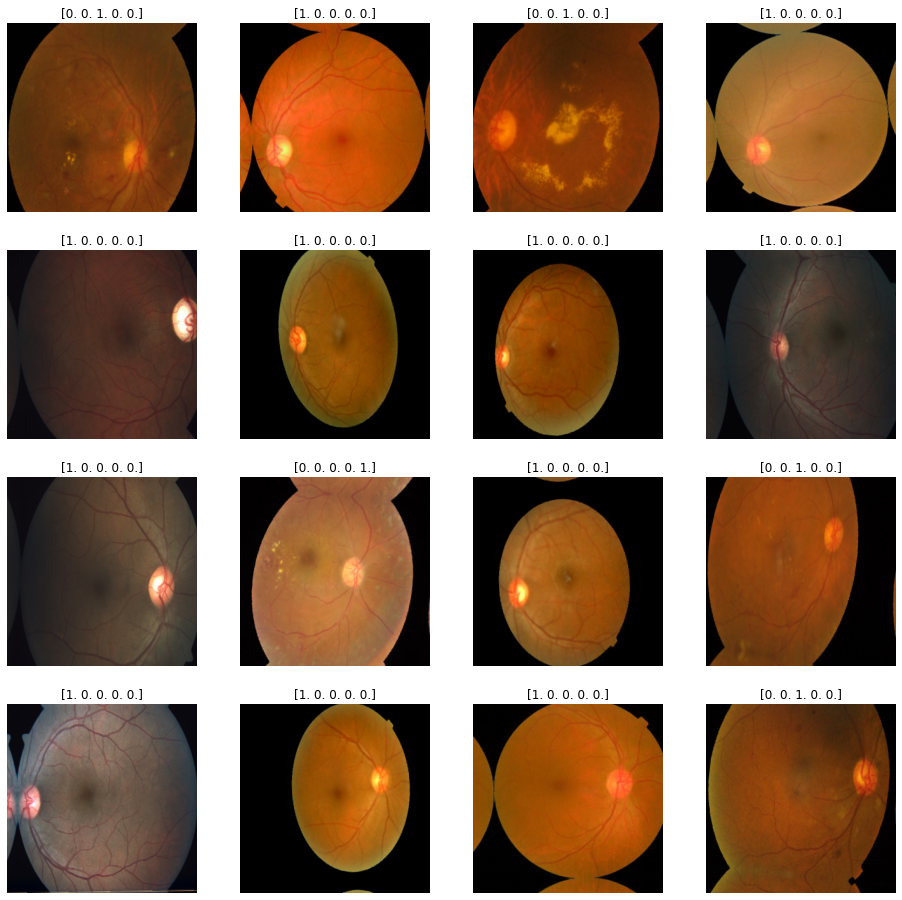

In [25]:
plt.figure(figsize=(16, 16))

for idx in range(16):
    ax = plt.subplot(4, 4, idx + 1)
    plt.imshow(image.array_to_img(train_images[idx]))
    plt.title(str(train_labels[idx]))
    plt.axis('off')

plt.show

## Check validation dataset

In [26]:
valid_generator[0][0].shape

(32, 299, 299, 3)

In [27]:
image_idx = valid_generator.index_array[1]
valid_generator.labels[image_idx]

0

In [28]:
fname = valid_generator.filenames[image_idx]
fname

'a44345b27804.jpeg'

In [29]:
df.loc[df['id_code'] == fname]

id_code diagnosis
2261  a44345b27804.jpeg         0

In [30]:
valid_images_7, valid_labels_7 = valid_generator[7]
print(valid_images_7.shape)
print(valid_labels_7.shape)

(32, 299, 299, 3)
(32, 5)


<function matplotlib.pyplot.show(close=None, block=None)>

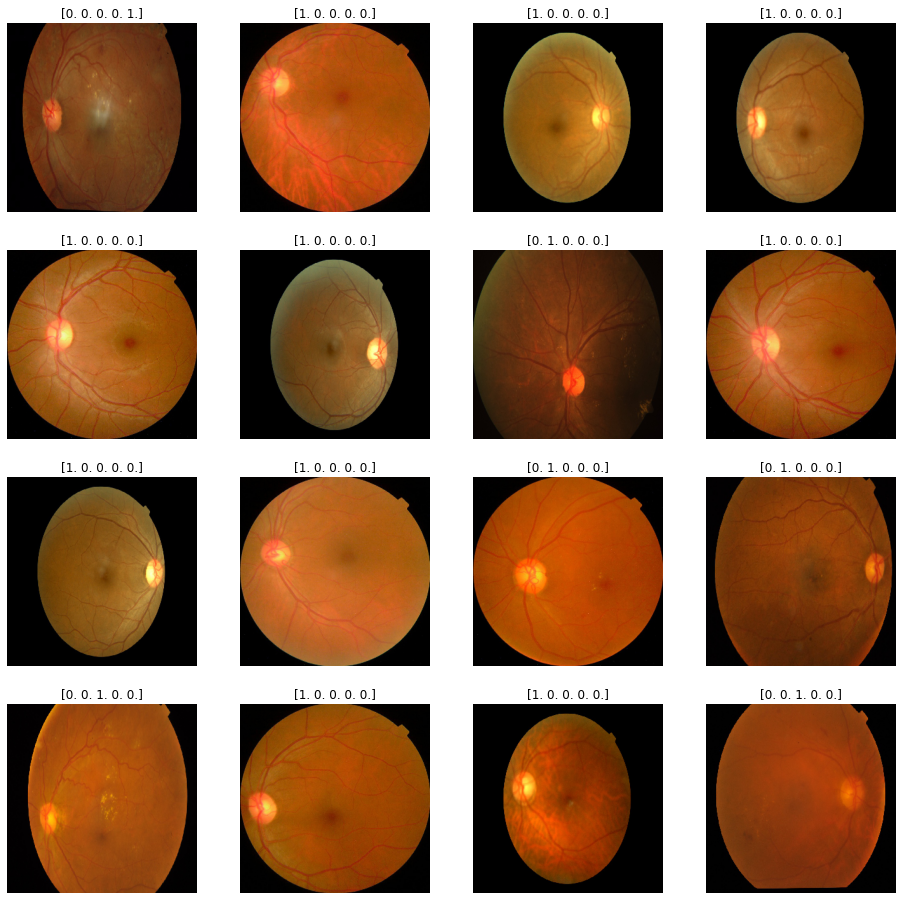

In [31]:
plt.figure(figsize=(16, 16))

for idx in range(16):
    ax = plt.subplot(4, 4, idx + 1)
    plt.imshow(image.array_to_img(valid_images_7[idx]))
    plt.title(str(valid_labels_7[idx]))
    plt.axis('off')

plt.show

# Original, without augmentasi

In [32]:
# we minimize the augmentation, in case preprocessing is destroyed?
train_datagen = image.ImageDataGenerator(data_format='channels_last')
test_datagen = image.ImageDataGenerator(data_format='channels_last')

## Check training dataset

In [33]:
fold = 5
df_train = df.iloc[dict_kfold['train_fold_' + str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_' + str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2799 validated image filenames belonging to 5 classes.
Found 699 validated image filenames belonging to 5 classes.


In [34]:
train_images, train_labels = train_generator[7]
print(train_images.shape)
print(train_labels.shape)

(32, 299, 299, 3)
(32, 5)


In [35]:
list_original_images = list()

for idx in range(16):
    list_original_images.append(train_images[idx])

<function matplotlib.pyplot.show(close=None, block=None)>

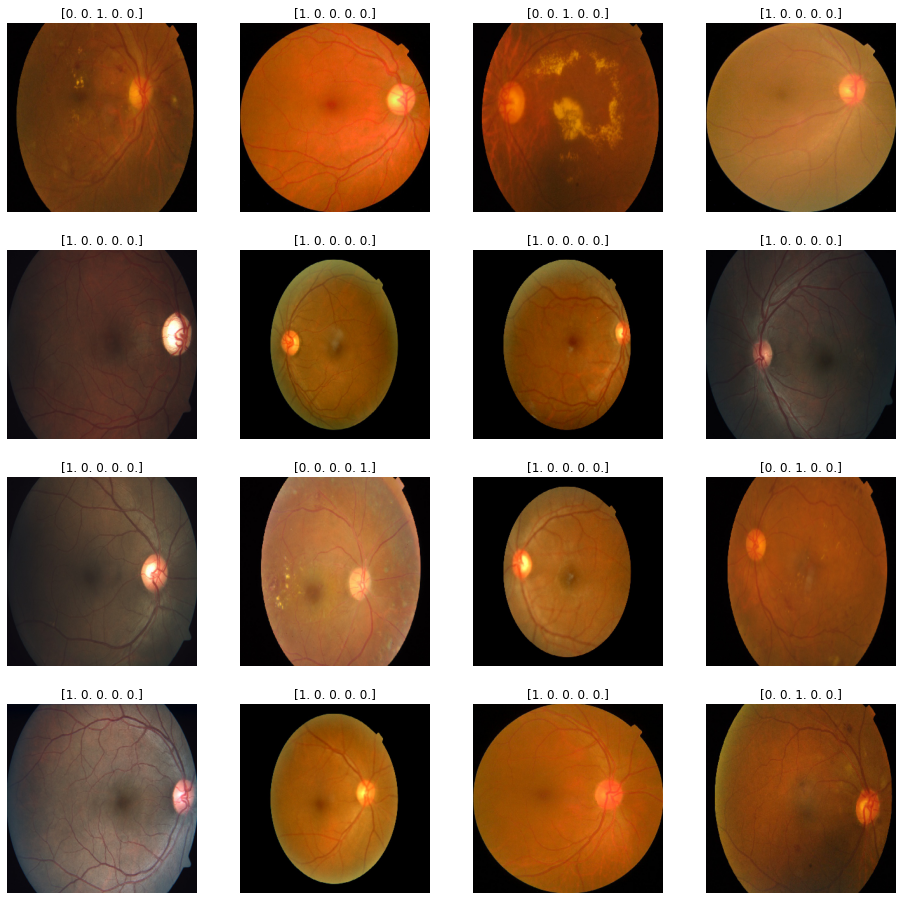

In [36]:
plt.figure(figsize=(16, 16))

for idx in range(16):
    ax = plt.subplot(4, 4, idx + 1)
    plt.imshow(image.array_to_img(train_images[idx]))
    plt.title(str(train_labels[idx]))
    plt.axis('off')

plt.show

# Shift augmentasi

In [37]:
# we minimize the augmentation, in case preprocessing is destroyed?
train_datagen = image.ImageDataGenerator(width_shift_range=0.1,
                                         height_shift_range=0.1,
                                         fill_mode='reflect',
                                         data_format='channels_last')
test_datagen = image.ImageDataGenerator(data_format='channels_last')

## Check training dataset

In [38]:
fold = 5
df_train = df.iloc[dict_kfold['train_fold_' + str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_' + str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2799 validated image filenames belonging to 5 classes.
Found 699 validated image filenames belonging to 5 classes.


In [39]:
train_images, train_labels = train_generator[7]
print(train_images.shape)
print(train_labels.shape)

(32, 299, 299, 3)
(32, 5)


<function matplotlib.pyplot.show(close=None, block=None)>

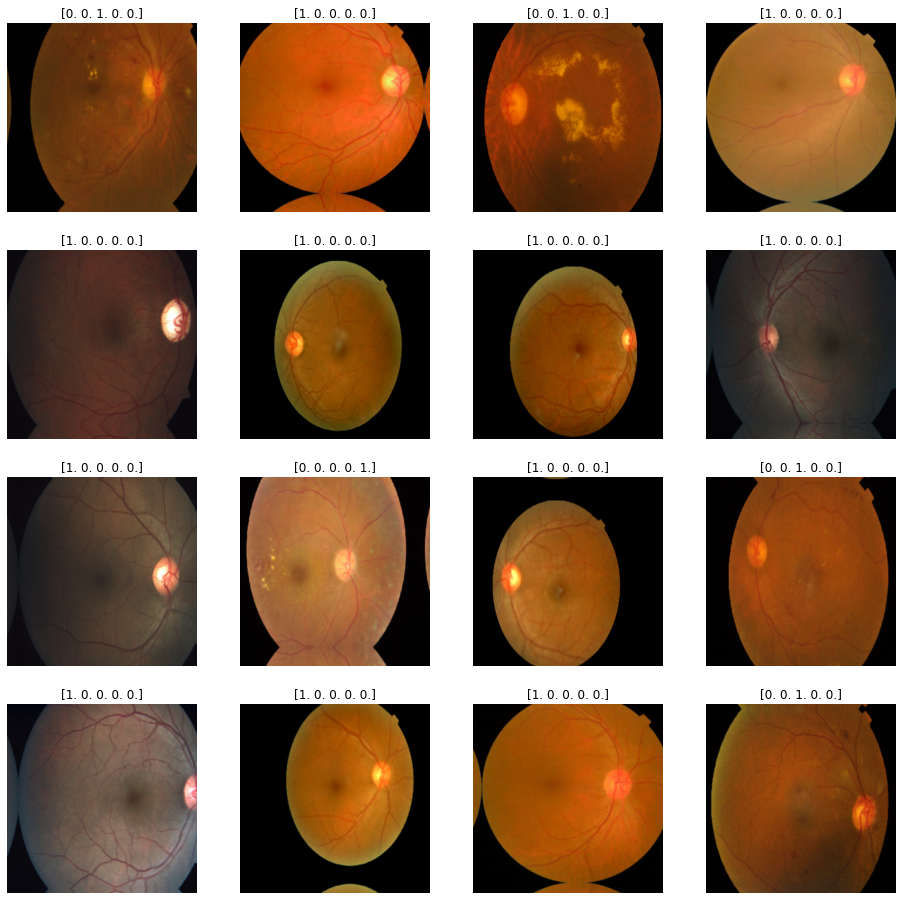

In [40]:
plt.figure(figsize=(16, 16))

for idx in range(16):
    ax = plt.subplot(4, 4, idx + 1)
    plt.imshow(image.array_to_img(train_images[idx]))
    plt.title(str(train_labels[idx]))
    plt.axis('off')

plt.show

# Flip augmentasi

In [41]:
# we minimize the augmentation, in case preprocessing is destroyed?
train_datagen = image.ImageDataGenerator(horizontal_flip=True,
                                         vertical_flip=True,
                                         fill_mode='reflect',
                                         data_format='channels_last')
test_datagen = image.ImageDataGenerator(data_format='channels_last')

## Check training dataset

In [42]:
fold = 5
df_train = df.iloc[dict_kfold['train_fold_' + str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_' + str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2799 validated image filenames belonging to 5 classes.
Found 699 validated image filenames belonging to 5 classes.


In [43]:
train_images, train_labels = train_generator[7]
print(train_images.shape)
print(train_labels.shape)

(32, 299, 299, 3)
(32, 5)


<function matplotlib.pyplot.show(close=None, block=None)>

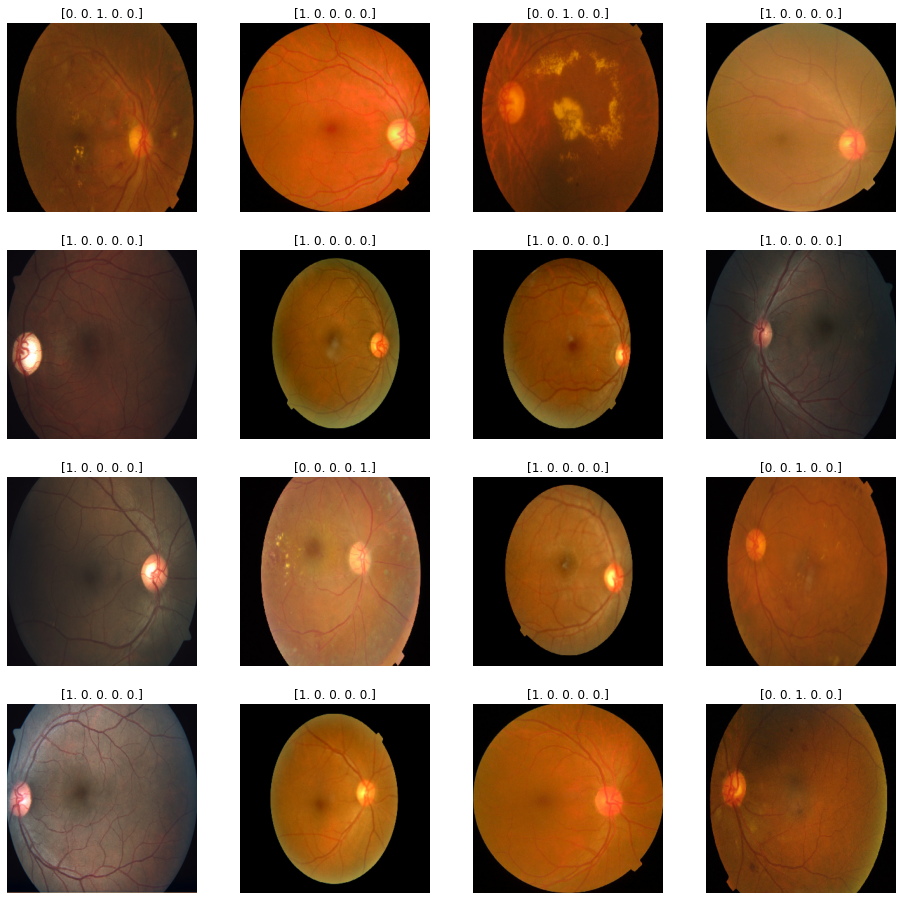

In [44]:
plt.figure(figsize=(16, 16))

for idx in range(16):
    ax = plt.subplot(4, 4, idx + 1)
    plt.imshow(image.array_to_img(train_images[idx]))
    plt.title(str(train_labels[idx]))
    plt.axis('off')

plt.show

# Zoom augmentasi

In [45]:
# we minimize the augmentation, in case preprocessing is destroyed?
train_datagen = image.ImageDataGenerator(zoom_range=0.1,
                                         fill_mode='reflect',
                                         data_format='channels_last')
test_datagen = image.ImageDataGenerator(data_format='channels_last')

## Check training dataset

In [46]:
fold = 5
df_train = df.iloc[dict_kfold['train_fold_' + str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_' + str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2799 validated image filenames belonging to 5 classes.
Found 699 validated image filenames belonging to 5 classes.


In [47]:
train_images, train_labels = train_generator[7]
print(train_images.shape)
print(train_labels.shape)

(32, 299, 299, 3)
(32, 5)


<function matplotlib.pyplot.show(close=None, block=None)>

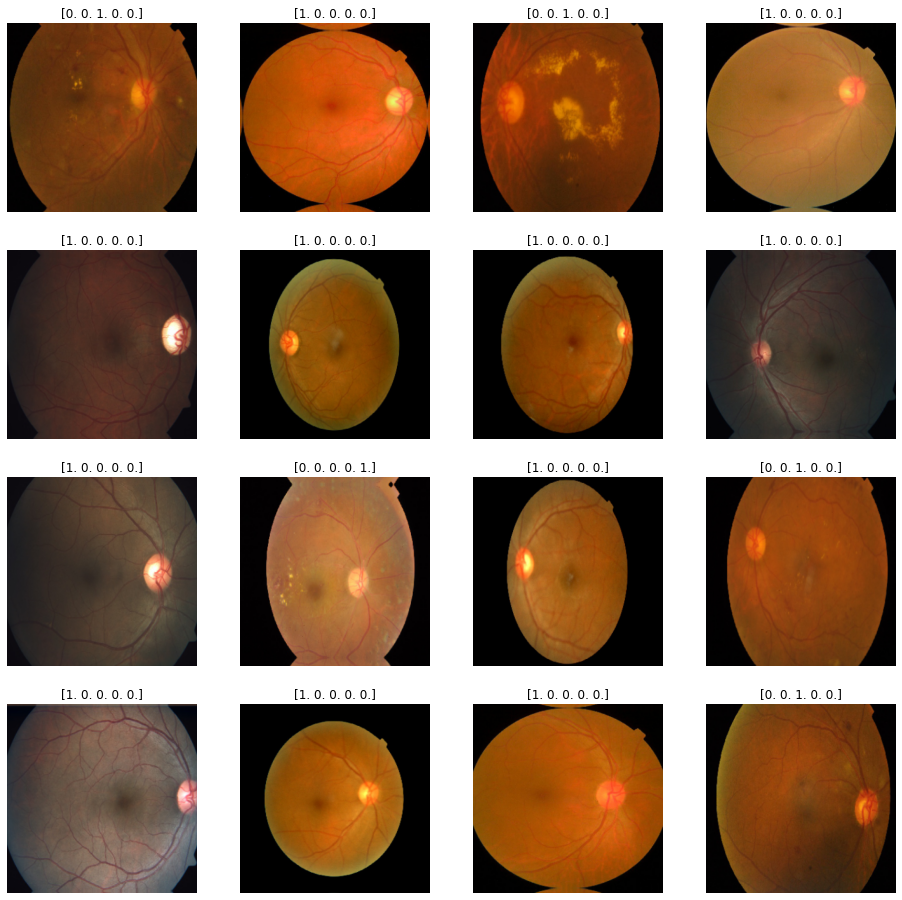

In [48]:
plt.figure(figsize=(16, 16))

for idx in range(16):
    ax = plt.subplot(4, 4, idx + 1)
    plt.imshow(image.array_to_img(train_images[idx]))
    plt.title(str(train_labels[idx]))
    plt.axis('off')

plt.show

# Rotate augmentasi

In [49]:
# we minimize the augmentation, in case preprocessing is destroyed?
train_datagen = image.ImageDataGenerator(rotation_range=10,
                                         fill_mode='reflect',
                                         data_format='channels_last')
test_datagen = image.ImageDataGenerator(data_format='channels_last')

## Check training dataset

In [50]:
fold = 5
df_train = df.iloc[dict_kfold['train_fold_' + str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_' + str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2799 validated image filenames belonging to 5 classes.
Found 699 validated image filenames belonging to 5 classes.


In [51]:
train_images, train_labels = train_generator[7]
print(train_images.shape)
print(train_labels.shape)

(32, 299, 299, 3)
(32, 5)


<function matplotlib.pyplot.show(close=None, block=None)>

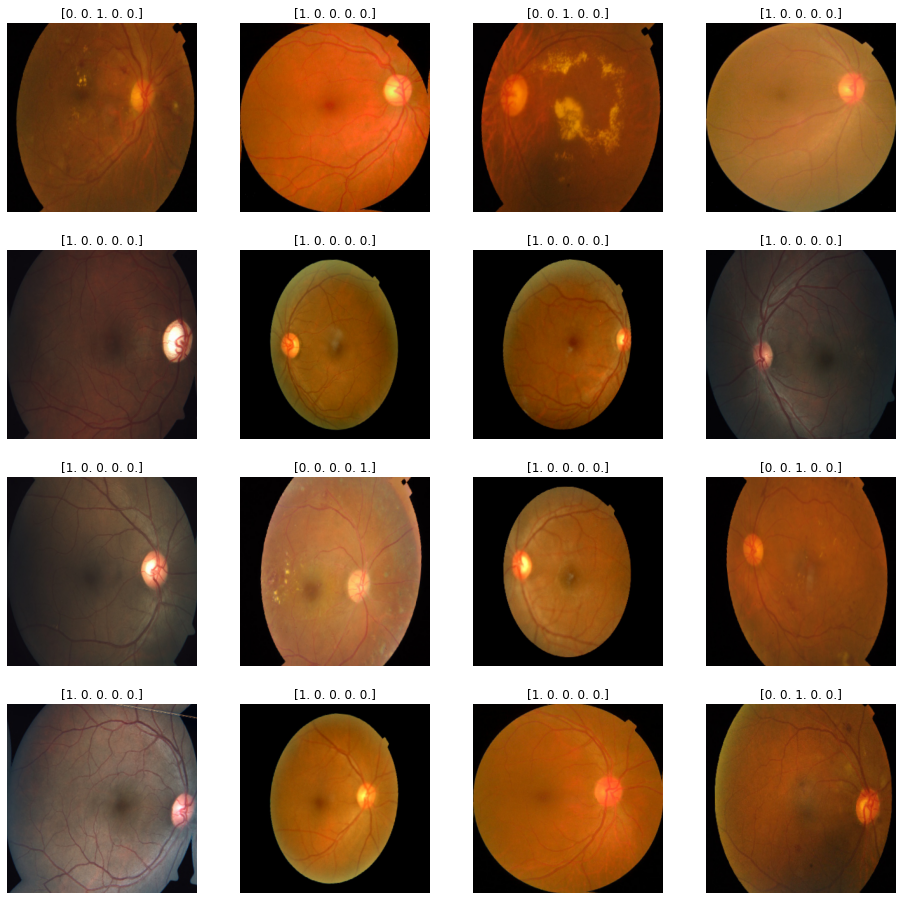

In [52]:
plt.figure(figsize=(16, 16))

for idx in range(16):
    ax = plt.subplot(4, 4, idx + 1)
    plt.imshow(image.array_to_img(train_images[idx]))
    plt.title(str(train_labels[idx]))
    plt.axis('off')

plt.show

# Shear augmentasi

In [36]:
# we minimize the augmentation, in case preprocessing is destroyed?
train_datagen = image.ImageDataGenerator(shear_range=0.1,
                                         fill_mode='reflect',
                                         data_format='channels_last')
test_datagen = image.ImageDataGenerator(data_format='channels_last')

## Check training dataset

In [37]:
fold = 5
df_train = df.iloc[dict_kfold['train_fold_' + str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_' + str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2799 validated image filenames belonging to 5 classes.
Found 699 validated image filenames belonging to 5 classes.


In [38]:
train_images, train_labels = train_generator[7]
print(train_images.shape)
print(train_labels.shape)

(32, 299, 299, 3)
(32, 5)


In [39]:
list_shear_images = list()

for idx in range(16):
    list_shear_images.append(train_images[idx])

<function matplotlib.pyplot.show(close=None, block=None)>

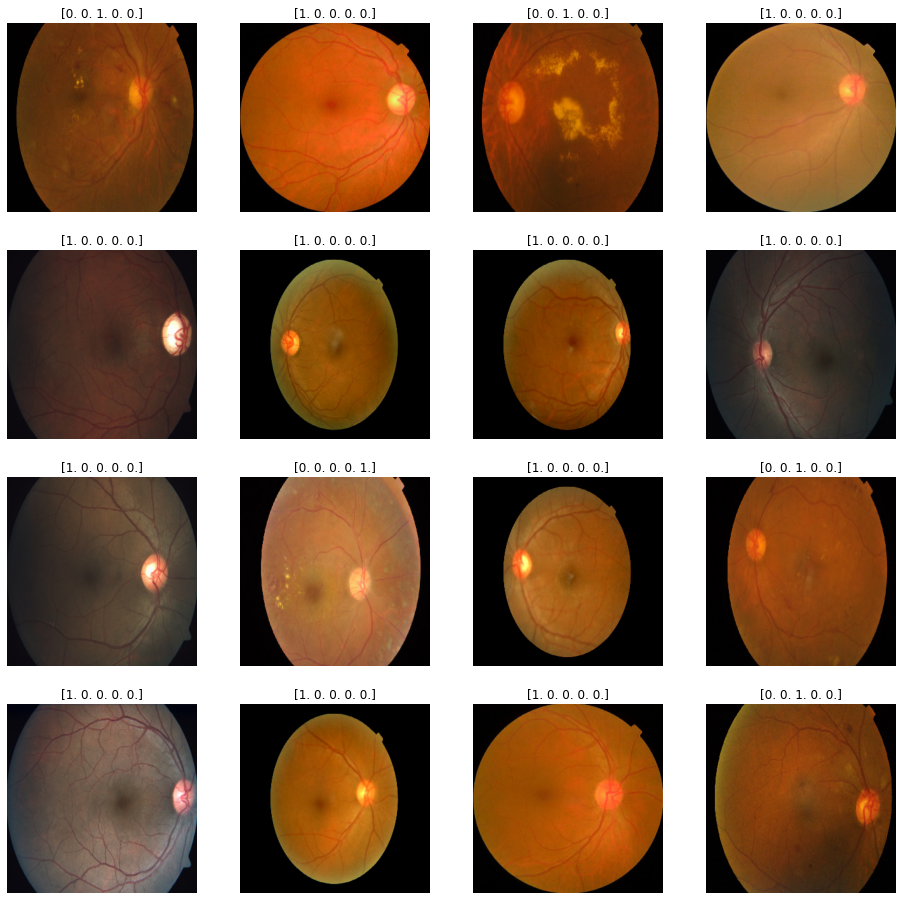

In [40]:
plt.figure(figsize=(16, 16))

for idx in range(16):
    ax = plt.subplot(4, 4, idx + 1)
    plt.imshow(image.array_to_img(train_images[idx]))
    plt.title(str(train_labels[idx]))
    plt.axis('off')

plt.show

In [42]:
list_delta_images = list()
for idx in range(16):
    list_delta_images.append(list_original_images[idx] - list_shear_images[idx])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<function matplotlib.pyplot.show(close=None, block=None)>

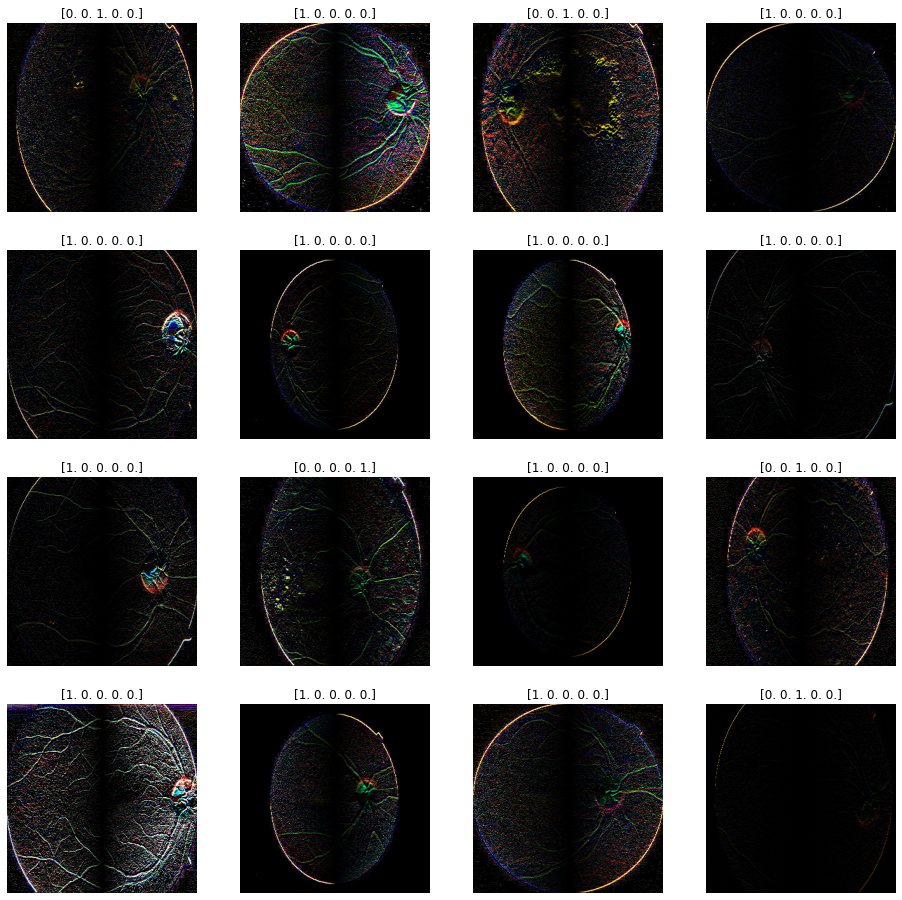

In [44]:
plt.figure(figsize=(16, 16))

for idx in range(16):
    ax = plt.subplot(4, 4, idx + 1)
    plt.imshow(list_delta_images[idx])
    plt.title(str(train_labels[idx]))
    plt.axis('off')

plt.show